<a href="https://colab.research.google.com/github/16A0/til/blob/master/interactive_masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latent Composition Interactive Masking

Demonstrates using a masked encoder to investigate image priors in GANs.

Related Colab Notebooks:
- [Interactive Composition Demo](https://colab.research.google.com/drive/1j7Bz9vdVnxzOgokawA39hCJZLTmVDq6_?usp=sharing): Interface to compose multiple images using masked encoder.
- [Finetune and Edit](https://colab.research.google.com/drive/1zpD_UYqiGqjzftYxHQPy4sxOQTWV_QY9?usp=sharing): For real images, finetune the encoder towards a specific image for better reconstruction. Further composition can be done in real time.


## Download code, models, and set up

In [1]:
! git clone https://github.com/chail/latent-composition.git

Cloning into 'latent-composition'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 318 (delta 146), reused 217 (delta 73), pack-reused 0
Receiving objects: 100% (318/318), 7.81 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [2]:
import os
os.chdir('latent-composition')

In [3]:
# required for stylegan models
! pip install ninja

     |████████████████████████████████| 108 kB 5.3 MB/s 


In [4]:
import torch
import numpy as np
from utils import show, renormalize, pbar
from utils import util, paintwidget, labwidget, imutil
from networks import networks
from PIL import Image
import os
from torchvision import transforms
import time

In [5]:
 os.environ['TORCH_EXTENSIONS_DIR'] = '/tmp/torch_cpp/' # needed for stylegan to run

In [6]:
assert(torch.cuda.is_available()) # check cuda is available

# Load Networks




In [7]:
#@title Select a model from the dropdown menu

dropdown = 'stylegan car' #@param ["stylegan car", "stylegan church", "stylegan horse", "stylegan ffhq", "proggan celebahq", "proggan church", "proggan livingroom"]

model_type, domain = dropdown.split()
nets = networks.define_nets(model_type, domain)
outdim = nets.setting['outdim']

Downloading: "http://latent-composition.csail.mit.edu/pretrained_models/sgans_stylegan2-car-config-f.pt" to /root/.cache/torch/hub/checkpoints/sgans_stylegan2-car-config-f.pt


  0%|          | 0.00/118M [00:00<?, ?B/s]

Using halfsize?: False
Input channels: 4
Using default checkpoint path: pretrained_models/sgan_encoders_car_RGBM_model_final.pth


Downloading: "http://latent-composition.csail.mit.edu/pretrained_models/sgan_encoders_car_RGBM_model_final.pth" to /root/.cache/torch/hub/checkpoints/sgan_encoders_car_RGBM_model_final.pth


  0%|          | 0.00/292M [00:00<?, ?B/s]

# Sample an image, and reencode it


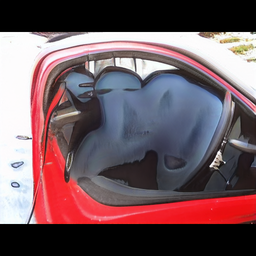

In [8]:
#@title Select the input image.

#@markdown Select a random seed to generate an image.
random_seed = 25 #@param {type:"slider", min:0, max:100, step:1}

#@markdown Uncheck this box if you want to use a real image instead.
use_g_sample = True #@param {type:"boolean"}


if use_g_sample:
    # use a gan image as source
    with torch.no_grad():
        source_z = nets.sample_zs(1, seed=random_seed)
        source_im = nets.zs2image(source_z)
    show(['Source Image', renormalize.as_image(source_im[0]).resize((256, 256), Image.LANCZOS)])
else:
    # use a real image as source 
    if domain != "car":
      print("!! WARNING !!: The default image is a car, please use the stylegan_car model or change im_path.")
    im_path = 'img/car0.png' # 'img/car1.png'
    transform = transforms.Compose([
                    transforms.Resize(outdim),
                    transforms.CenterCrop(outdim),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])    
    source_im = transform(Image.open(im_path))[None].cuda()
    show(['Source Image', renormalize.as_image(source_im[0]).resize((256, 256), Image.LANCZOS)])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



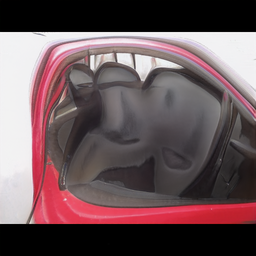

In [9]:
with torch.no_grad():
    out = nets.invert(source_im)
    show(['Inverted Image', renormalize.as_image(out[0]).resize((256, 256), Image.LANCZOS)])

# Visualize network priors
Drag your mouse on the left panel, and the GAN reconstruction will show in the right panel


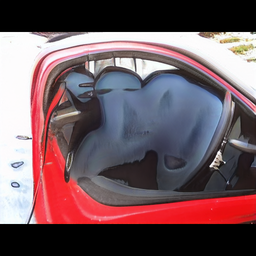
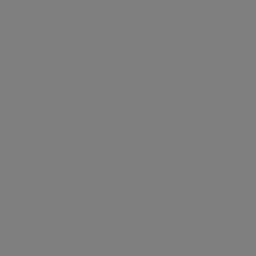
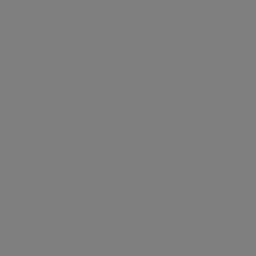

In [10]:
src_painter = paintwidget.PaintWidget(oneshot=False, width=256, height=256, 
                                      brushsize=20, save_sequence=False, track_move=True) # , on_move=True)
src_painter.image = renormalize.as_url(source_im[0], size=256)

img_url = renormalize.as_url(torch.zeros(3, 256, 256))
img_html = '<img src="%s"/>'%img_url
output_div = labwidget.Div(img_html)

counter = 0
prev_time = time.time()
update_freq = 0.5 # mouse time intervals;  
# decrease update_freq to reduce lagging, but colab is kind of slow
mask_list = []
reconstruction_list = []

def probe_changed(c):
    global counter
    global prev_time
    counter += 1
    curr_time = time.time()
    if curr_time - prev_time < update_freq:
        return
    prev_time = time.time()
    
    mask_url = src_painter.mask_buffer
    mask =  renormalize.from_url(mask_url, target='pt', size=(outdim, outdim)).cuda()[None] # 1x3xHxW
    with torch.no_grad():
        mask = mask[:, [0], :, :] # 1x1xHxW
        mask_list.append(mask.cpu())
        masked_im = source_im * mask
        regenerated_mask = nets.invert(masked_im, mask)
    img_url = renormalize.as_url(regenerated_mask[0], size=256)
    img_html = '<img src="%s"/>'%img_url
    output_div.innerHTML = img_html
    reconstruction_list.append(renormalize.as_image(regenerated_mask[0]))
    
src_painter.on('mask_buffer', probe_changed)

show.a([src_painter], cols=2)
show.a([output_div], cols=2)

show.flush()


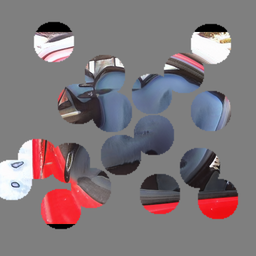
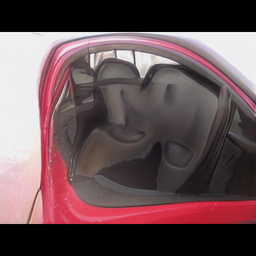

In [14]:
show.a(['Masked Input', renormalize.as_image((mask_list[-1] * source_im.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['Reconstruction', reconstruction_list[-1].resize((256,256), Image.ANTIALIAS)])
show.flush()